In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lime
import lime.lime_tabular
import shap

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC

# sharp plots with higher resolution
%config InlineBackend.figure_format = 'svg'
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 150

## Case 1: Two uniformly distributed classes

In [4]:
n_1 = 1000
n_2 = 1000

class_1 = np.random.uniform([0, 0], [0.4, 1], (n_1, 2))
class_2 = np.random.uniform([0.6, 0], [1,1], (n_2, 2))

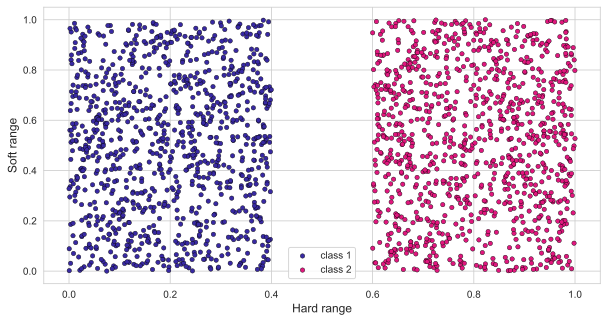

In [5]:
fig = plt.figure(figsize=(10, 5))
s1 = plt.scatter(class_1[:,0],class_1[:,1], s=20, color='#3829a3', edgecolors='k', linewidths=0.4)
s2 = plt.scatter(class_2[:,0],class_2[:,1], s=20, color='#e1177e', edgecolors='k', linewidths=0.4)
plt.xlabel('Hard range', fontsize=12)
plt.ylabel('Soft range', fontsize=12)
plt.legend([s1,s2], ['class 1', 'class 2'])
plt.show()

In [6]:
# class labels
labels_1 = np.zeros((n_1, 1))
labels_2 = np.ones((n_2, 1))

X0 = np.vstack([class_1, class_2]) # features
y0 = np.hstack([np.zeros(n_1), np.ones(n_2,)]) # labels - 0 or 1

In [7]:
# split into train/test data
X, y = X0.copy(), y0.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.2)

### Dummy clasifier 

In [8]:
clf_dm = DummyClassifier(strategy='most_frequent')
clf_dm.fit(X_train, y_train)
accuracy_score(y_test, clf_dm.predict(X_test)) # it's not bad at all

0.4875

### SVM classifier with linear kernel

In [9]:
clf_lk = SVC(kernel='linear', probability=True)
clf_lk.fit(X_train, y_train);
clf_lk.score(X_test,y_test) # the data are nicely linearly separable -> perfect accuracy

1.0

In [10]:
# function that helps to plot the decision boundary
def plot_SVCclassification(sig1,sig2,clf,xmax,ymax,lgd):
    grid=20
    xx,yy = np.meshgrid(np.linspace(0, xmax, grid),np.linspace(0, ymax, grid))
    X_ = np.array([np.ravel(xx), np.ravel(yy)]).T
    zz = clf.decision_function(X_).reshape(grid,grid)
    cs = plt.contourf(xx,yy,zz, zz,levels=[-float("inf"),0,float("inf")],alpha=0.8,colors=['#f2f6ff','#faf2f6'])
    plt.contour(cs, colors='k')
    
    s1 = plt.scatter(sig1[:,0], sig1[:,1], color='#3829a3', edgecolors='k', linewidths=0.4)
    s2 = plt.scatter(sig2[:,0], sig2[:,1], color='#e1177e', edgecolors='k', linewidths=0.4)
    plt.xlabel('Hard margin', fontsize=12)
    plt.ylabel('Soft margin', fontsize=12)
    plt.legend([s1,s2], [lgd[0],lgd[1]], bbox_to_anchor=(0.5, 1.1), loc='upper center', ncol=2)

In [11]:
X_testF = X_test[y_test == 0]
X_testF2 = X_test[y_test == 1]

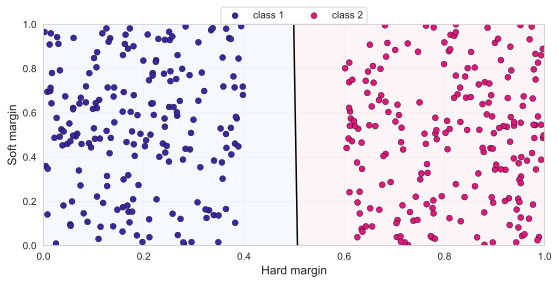

In [12]:
fig = plt.figure(figsize=(9, 4))
plot_SVCclassification(X_testF,X_testF2,clf_lk,1,1,['class 1', 'class 2'])
plt.show()

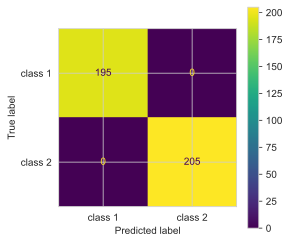

In [13]:
# plot the confusion matrix
cm = confusion_matrix(y_test, clf_lk.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['class 1','class 2'])
fig, ax = plt.subplots(figsize=(4,4))
disp.plot(ax=ax)
plt.show()

### Add LIME based explainer

In [14]:
# LIME explainer for for two features and two classes
explainer = lime.lime_tabular.LimeTabularExplainer(training_data=X_train, feature_names=["feat1","feat2"],
                                                  class_names=["class1","class2"], mode='classification')

In [15]:
# Choose the 1st instance (2nd element) and use it to predict the results
j = 1
exp = explainer.explain_instance(data_row=X_test[j], predict_fn=clf_lk.predict_proba)

In [16]:
X_test[j] # check the values

array([0.67005076, 0.16226598])

In [17]:
y_test[j] # and class

1.0

In [18]:
# visualize predictions
exp.show_in_notebook(show_table=True,show_all=True)

In [19]:
# numeric representation
exp.as_list()

[('0.40 < feat1 <= 0.79', 0.6593119938188794),
 ('feat2 <= 0.27', -0.015153192793238821)]

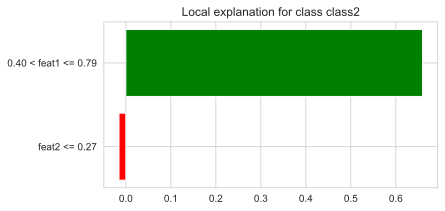

In [20]:
# another way to visualize the explanations
lime_figure = exp.as_pyplot_figure()
lime_figure.set_size_inches(6, 3)
plt.show()

### Add SHAP values based explainer

In [21]:
shap.initjs()

In [22]:
clf_lk2 = SVC(kernel='linear', probability=True)
clf_lk2.fit(X_train, y_train);
clf_lk2.score(X_test,y_test) # the data are nicely linearly separable -> perfect accuracy

1.0

In [23]:
explainer = shap.KernelExplainer(clf_lk.predict_proba, X_train)
shap_values = explainer.shap_values(X_test)

Using 1600 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/400 [00:00<?, ?it/s]

In [28]:
shap.force_plot(explainer.expected_value[0], shap_values[0][0, :], X_test[0, :])

KeyboardInterrupt: 

In [25]:
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


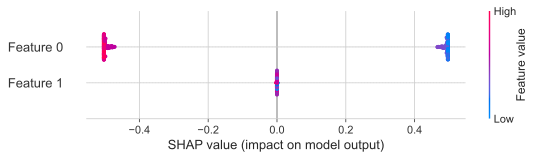

In [26]:
shap.summary_plot(shap_values[0], X_test)

### SVM classifier with polynomial kernel

In [28]:
clf_pk = SVC(kernel='poly', degree=5, coef0=10)
clf_pk.fit(X_train, y_train);
clf_pk.score(X_test,y_test)

1.0

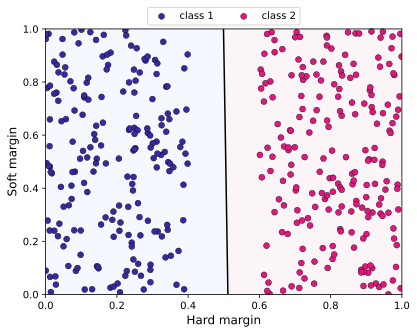

In [29]:
plot_SVCclassification(X_testF,X_testF2,clf_pk,1,1,['class 1', 'class 2'])
plt.show()

### SVM classifier with RBF kernel

In [31]:
clf_rbf = SVC(kernel='rbf', C=100, gamma=1e-03)
clf_rbf.fit(X_train, y_train);
clf_rbf.score(X_test,y_test)

1.0

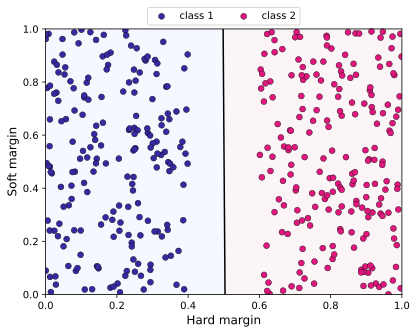

In [32]:
plot_SVCclassification(X_testF,X_testF2,clf_rbf,1,1,['class 1', 'class 2'])
plt.show()

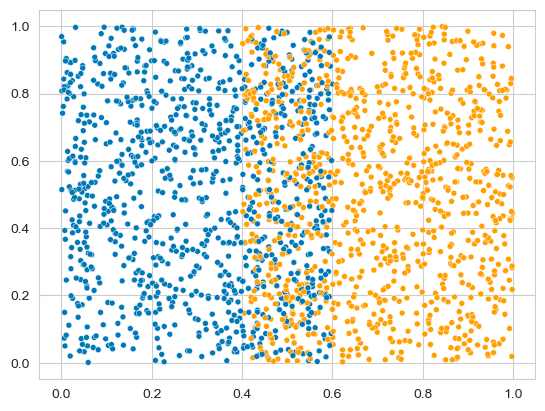

In [4]:
class_1 = np.random.uniform([0, 0], [0.6, 1], (n_1, 2))
class_2 = np.random.uniform([0.4, 0], [1,1], (n_2, 2))

labels_1 = np.zeros((n_1, 1))
labels_2 = np.ones((n_2, 1))

class_1_1 = np.hstack([class_1, labels_1])
class_2_1 = np.hstack([class_2, labels_2])

data_set_uf_sm_l = np.vstack([class_1_1, class_2_1])
np.random.shuffle(data_set_uf_sm_l)

fig_2, ax_2 = plt.subplots()
ax_2 = sns.scatterplot(x=data_set_uf_sm_l[:, 0], y=data_set_uf_sm_l[:, 1], hue=data_set_uf_sm_l[:, 2], size=1)
plt.legend([],[], frameon=False)
plt.show()
data_sets['uniform_soft_margin_straight_line'] = data_set_uf_sm_l

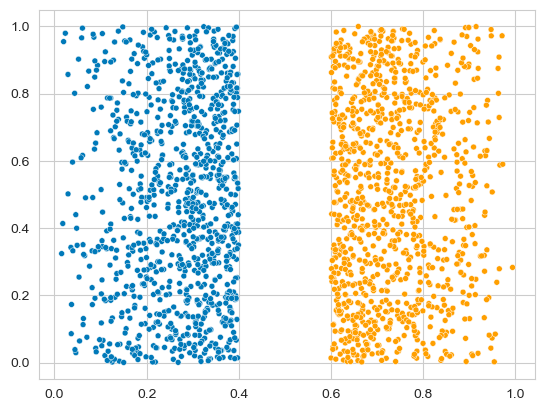

In [5]:
class_3 = np.random.beta([2, 1], [1, 1], size=(n_1, 2))
class_4 = np.random.beta([2, 1], [1, 1], size=(n_1, 2))
class_3[:, 0] = class_3[:, 0] * 0.4
class_4[:, 0] = class_4[:, 0] * -0.4 +1

class_3_1 = np.hstack([class_3, labels_1])
class_4_1 = np.hstack([class_4, labels_2])

data_set_beta_hm_l = np.vstack([class_3_1, class_4_1])
np.random.shuffle(data_set_beta_hm_l)

fig_3, ax_3 = plt.subplots()
ax_3=sns.scatterplot(x=data_set_beta_hm_l[:, 0], y=data_set_beta_hm_l[:, 1], hue=data_set_beta_hm_l[:, 2], size=1)
plt.legend([],[], frameon=False)
plt.show()

data_sets['beta_hard_margin_straight_line'] = data_set_beta_hm_l

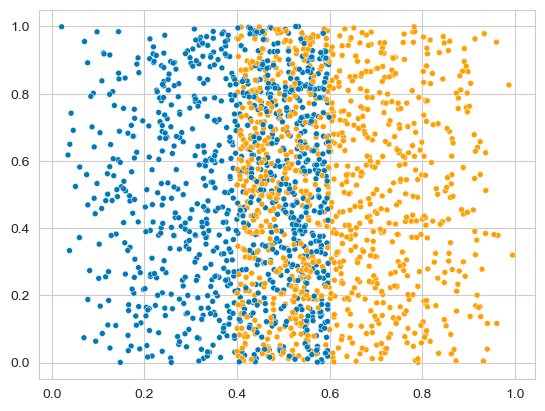

In [6]:
class_3 = np.random.beta([2, 1], [1, 1], size=(n_1, 2))
class_4 = np.random.beta([2, 1], [1, 1], size=(n_1, 2))
class_3[:, 0] = class_3[:, 0] * 0.6
class_4[:, 0] = class_4[:, 0] * -0.6 +1

class_3_1 = np.hstack([class_3, labels_1])
class_4_1 = np.hstack([class_4, labels_2])

data_set_beta_sm_l = np.vstack([class_3_1, class_4_1])
np.random.shuffle(data_set_beta_sm_l)

fig_4, ax_4 = plt.subplots()
ax_4 = sns.scatterplot(x=data_set_beta_sm_l[:, 0], y=data_set_beta_sm_l[:, 1], hue=data_set_beta_sm_l[:, 2], size=1)
plt.legend([],[], frameon=False)
plt.show()
data_sets['beta_soft_margin_straight_line'] = data_set_beta_sm_l

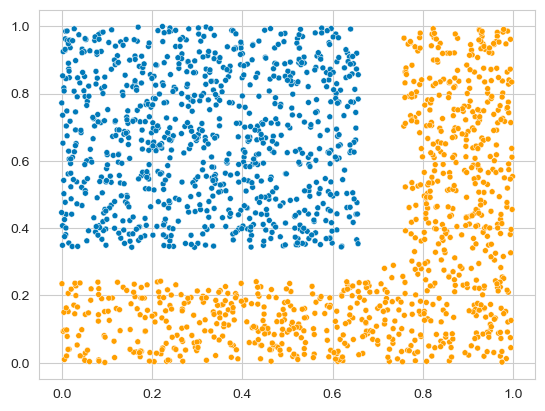

In [7]:
l = 1
mu_x = 0.5
mu_y = 0.5
class_5 = np.random.uniform([mu_x-l/2, mu_y-l/2], [mu_x+l/2, mu_y+l/2], (n_1+n_2, 2))
class_5_1 = class_5[class_5[:, 0]>l/np.sqrt(2),:]
class_5_2 = class_5[class_5[:, 0]<l/np.sqrt(2),:]
class_5_3 = class_5_2[class_5_2[:, 1] < l * (1- 1/np.sqrt(2)), :]
class_5_2 = class_5_2[class_5_2[:, 1] > l * (1- 1/np.sqrt(2)), :]
class_5_4 = class_5_1[class_5_1[:, 1] < l * (1- 1/np.sqrt(2)), :]
class_5_1 = class_5_1[class_5_1[:, 1] > l * (1- 1/np.sqrt(2)), :]

class_5_2_1 = class_5_2[class_5_2[:, 0] < l/np.sqrt(2) - l * 0.05]
class_5_2_1 = class_5_2_1[class_5_2_1[:, 1] > l * (1- 1/np.sqrt(2)) + l *0.05]
class_5_1_1 = class_5_1[class_5_1[:, 0] > l/np.sqrt(2) + l * 0.05]
class_5_3_1 = class_5_3[class_5_3[:, 1] < l * (1- 1/np.sqrt(2)) - l *0.05]


#class_5 = class_5_2[class_5_2[:, 1]>l*(1-1/np.sqrt(2))+0.1, :]
class_5 = class_5_2_1
class_6 = np.vstack([class_5_1_1, class_5_3_1, class_5_4])


labels_1_1=np.zeros((len(class_5), 1))
labels_2_1=np.ones((len(class_6), 1))

class_5_1 = np.hstack([class_5, labels_1_1])
class_6_1 = np.hstack([class_6, labels_2_1])

#class_6_1[:, 0] = class_6_1[:, 0] + 0.2
#class_6_1[:, 1] = class_6_1[:, 1] - 0.2

data_set_uf_hm_sq = np.vstack([class_5_1, class_6_1])

fig_5, ax_5 = plt.subplots()
ax_5 = sns.scatterplot(x=data_set_uf_hm_sq[:, 0], y=data_set_uf_hm_sq[:, 1], hue=data_set_uf_hm_sq[:, 2], size=1)
plt.legend([],[], frameon=False)
plt.show()

data_sets['uniform_hard_margin_corner'] = data_set_uf_hm_sq

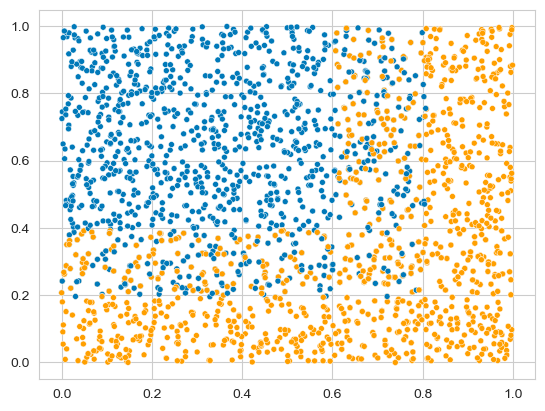

In [8]:
l = 1
mu_x = 0.5
mu_y = 0.5
class_5 = np.random.uniform([mu_x-l/2, mu_y-l/2], [mu_x+l/2, mu_y+l/2], (n_1+n_2, 2))
class_5_1 = class_5[class_5[:, 0]>l/np.sqrt(2) - l * 0.1,:]
class_5_2 = class_5[class_5[:, 0]<l/np.sqrt(2) + l * 0.1,:]
class_5_3 = class_5_2[class_5_2[:, 1] < l * (1- 1/np.sqrt(2)) + l * 0.1, :]
class_5_2 = class_5_2[class_5_2[:, 1] > l * (1- 1/np.sqrt(2)) - l * 0.1, :]
class_5_4 = class_5_1[class_5_1[:, 1] < l * (1- 1/np.sqrt(2)) + l * 0.1, :]
class_5_1 = class_5_1[class_5_1[:, 1] > l * (1- 1/np.sqrt(2)) - l * 0.1, :]

#class_5_2_1 = class_5_2[class_5_2[:, 0] < l/np.sqrt(2) - l * 0.05]
#class_5_2_1 = class_5_2_1[class_5_2_1[:, 1] > l * (1- 1/np.sqrt(2)) + l *0.05]
#class_5_1_1 = class_5_1[class_5_1[:, 0] > l/np.sqrt(2) + l * 0.05]
#class_5_3_1 = class_5_3[class_5_3[:, 1] < l * (1- 1/np.sqrt(2)) - l *0.05]

#class_5 = class_5_2[class_5_2[:, 1]>l*(1-1/np.sqrt(2))+0.1, :]
class_7 = class_5_2
class_8 = np.vstack([class_5_1, class_5_3, class_5_4])


labels_1_1=np.zeros((len(class_7), 1))
labels_2_1=np.ones((len(class_8), 1))

class_7 = np.hstack([class_7, labels_1_1])
class_8 = np.hstack([class_8, labels_2_1])

data_set_uf_sm_sq = np.vstack([class_7, class_8])
np.random.shuffle(data_set_uf_sm_sq)

fig_6, ax_6 = plt.subplots()
ax_6 = sns.scatterplot(x=data_set_uf_sm_sq[:, 0], y=data_set_uf_sm_sq[:, 1], hue=data_set_uf_sm_sq[:, 2], size=1)
plt.legend([],[], frameon=False)
plt.show()
data_sets['uniform_soft_margin_corner'] = data_set_uf_sm_sq

In [9]:
def gaussian_generator(center, eig_val, eig_vec, size):
    sigma = np.matmul(np.matmul(eig_vec, eig_val), np.transpose(eig_vec))
    data_set = np.random.multivariate_normal(center, sigma, size)

    return data_set

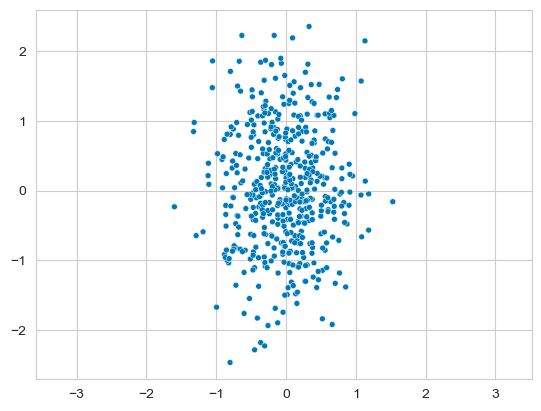

In [10]:
n_1 = 500  # number of the elements
mu_1 = np.array([0, 0])  # center (centroid)

# sigma is expected to be positive  semi-definite matrix
w_1 = np.array([[1.5, 0], [0, 4.5]])  # eigenvalues
v_1 = np.array([[0.4, 0], [0, 0.4]])  # eigenvectors

data_set = gaussian_generator(mu_1,w_1, v_1, n_1)
fig_6_1, ax_6_1 = plt.subplots()
ax_6_1= sns.scatterplot(x =data_set[:, 0],  y= data_set[:, 1],size=1)
ax_6_1.axis('equal')
plt.legend([],[], frameon=False)
plt.show()

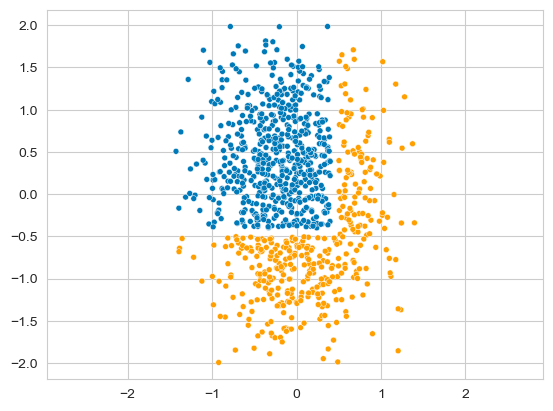

In [11]:
n_1 = 1000  # number of the elements
mu_1 = np.array([0, 0])  # center (centroid)

# sigma is expected to be positive  semi-definite matrix
w_1 = np.array([[1.5, 0], [0, 4.5]])  # eigenvalues
v_1 = np.array([[0.4, 0], [0, 0.4]])  # eigenvectors

set_1 = gaussian_generator(mu_1,w_1, v_1, n_1)

set_1_1 = set_1[set_1[:, 0] > 0.5, :]
set_1_2 = set_1[set_1[:, 0] < 0.5, :]

set_1_3 = set_1_1[set_1_1[:, 1] < -0.5, :]
set_1_1 = set_1_1[set_1_1[:, 1] > -0.5, :]
set_1_4 = set_1_2[set_1_2[:, 1] < -0.5, :]
set_1_2= set_1_2[set_1_2[:, 1] > -0.5, :]

set_2_1 = set_1_1
set_2_2 = set_1_2
set_2_3 = set_1_3
set_2_4 = set_1_4

set_2_1 = set_2_1
set_2_2[:, 0] = set_2_2[:, 0] - 0.1
set_2_2[:, 1] = set_2_2[:, 1] + 0.1
set_2_4 = set_2_4
set_2_3[:, 0] = set_2_3[:, 0]
set_2_3[:, 1] = set_2_3[:, 1]

class_9 = set_2_2
class_10 = np.vstack([set_2_1, set_2_3, set_2_4])

labels_9 = np.zeros((len(class_9), 1))
labels_10 = np.ones((len(class_10), 1))

class_9 = np.hstack([class_9, labels_9])
class_10 = np.hstack([class_10, labels_10])

data_set_norm_hm_sq = np.vstack([class_9, class_10])
np.random.shuffle(data_set_norm_hm_sq)

data_set_norm_hm_sq = data_set_norm_hm_sq[data_set_norm_hm_sq[:, 0] < 2, :]
data_set_norm_hm_sq = data_set_norm_hm_sq[data_set_norm_hm_sq[:, 0] > -2, :]

data_set_norm_hm_sq = data_set_norm_hm_sq[data_set_norm_hm_sq[:, 1] < 2, :]
data_set_norm_hm_sq = data_set_norm_hm_sq[data_set_norm_hm_sq[:, 1] > -2, :]


fig_7, ax_7 = plt.subplots()
ax_7= sns.scatterplot(x =data_set_norm_hm_sq[:, 0],  y= data_set_norm_hm_sq[:, 1], hue=data_set_norm_hm_sq[:, 2],size=1)
ax_7.axis('equal')
plt.legend([],[], frameon=False)
plt.show()
data_sets['normal_hard_margin_corner'] = data_set_norm_hm_sq

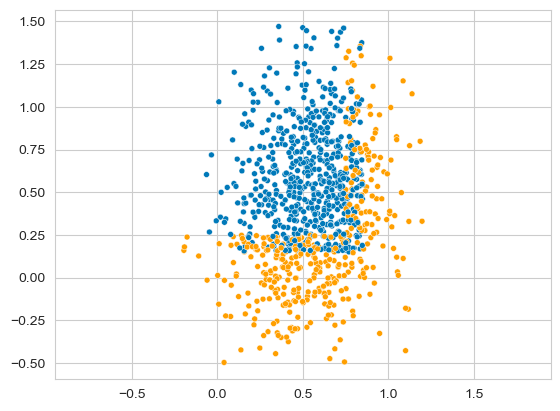

In [12]:
set_2_1 = set_1_1
set_2_2 = set_1_2
set_2_3 = set_1_3
set_2_4 = set_1_4

set_2_1 = set_2_1
set_2_2[:, 0] = set_2_2[:, 0] + 0.3
set_2_2[:, 1] = set_2_2[:, 1] - 0.3
set_2_4 = set_2_4
set_2_3[:, 0] = set_2_3[:, 0]
set_2_3[:, 1] = set_2_3[:, 1]

class_9 = set_2_2
class_10 = np.vstack([set_2_1, set_2_3, set_2_4])

labels_9 = np.zeros((len(class_9), 1))
labels_10 = np.ones((len(class_10), 1))

class_9 = np.hstack([class_9, labels_9])
class_10 = np.hstack([class_10, labels_10])

data_set_norm_sm_sq = np.vstack([class_9, class_10])
np.random.shuffle(data_set_norm_sm_sq)

data_set_norm_sm_sq = data_set_norm_sm_sq[data_set_norm_sm_sq[:, 0] < 2, :]
data_set_norm_sm_sq = data_set_norm_sm_sq[data_set_norm_sm_sq[:, 0] > -2, :]

data_set_norm_sm_sq = data_set_norm_sm_sq[data_set_norm_sm_sq[:, 1] < 2, :]
data_set_norm_sm_sq = data_set_norm_sm_sq[data_set_norm_sm_sq[:, 1] > -2, :]

data_set_norm_sm_sq[:, 0:2] = data_set_norm_sm_sq[:, 0:2] * 0.5
data_set_norm_sm_sq[:, 0] = data_set_norm_sm_sq[:, 0] + 0.5
data_set_norm_sm_sq[:, 1] = data_set_norm_sm_sq[:, 1] + 0.5

with open('practice_data_set.pkl', 'wb') as handle:
    pkl.dump(data_set_norm_sm_sq, handle)
handle.close()

fig_8, ax_8 = plt.subplots()
ax_8 = sns.scatterplot(x=data_set_norm_sm_sq[:, 0],  y=data_set_norm_sm_sq[:, 1],  hue=data_set_norm_sm_sq[:, 2], size=1)
ax_8.axis('equal')
plt.legend([],[], frameon=False)
plt.show()
data_sets['normal_soft_margin_corner'] = data_set_norm_sm_sq